Генерируем случайную матрицу размера nxn фиксированного ранга r. Для начала, генерируем произвольную матрицу A и вычисляем ее сингулярное разложение. A=U*S*V

In [1]:
import numpy as np
n=10
r=2
a=np.random.rand(n,n)
(u,s,v)=np.linalg.svd(a)
a

(10, 10)

In [2]:
np.linalg.matrix_rank(a)

10

In [3]:
s

array([5.08927325, 1.39001694, 1.29967144, 1.07892203, 0.77139686,
       0.68018123, 0.49241182, 0.36104805, 0.26472254, 0.05640903])

Вектор s -- сингулярные значения матрицы A. Теперь оставим в s только первые r значений, а остальные заменим 0.

In [4]:
s_cut=np.zeros(n)
s_cut[:r]=s[:r]

In [5]:
s_cut

array([5.08927325, 1.39001694, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

Дальше восстановим по тем же формулам, но с урезанным s, матрицу A.

In [6]:
s_mat=np.diag(s_cut)
a_new=u.dot(s_mat).dot(v)

In [7]:
a_new.shape

(10, 10)

In [8]:
np.linalg.matrix_rank(a_new)

2

In [9]:
a_new

array([[0.20947436, 0.61912177, 0.29032454, 0.49659149, 0.57635656,
        0.68852136, 0.83273979, 0.33619584, 0.7026359 , 0.58022191],
       [0.28090265, 0.54677421, 0.31903271, 0.40447244, 0.51034349,
        0.55679029, 0.702029  , 0.35539266, 0.6218852 , 0.54788062],
       [0.25645963, 0.6848941 , 0.33731884, 0.54055596, 0.63793055,
        0.74844416, 0.9125926 , 0.38699282, 0.77763   , 0.6510061 ],
       [0.59751642, 0.50085161, 0.51441789, 0.24957579, 0.47222391,
        0.32814427, 0.52458486, 0.53299913, 0.57446397, 0.62765358],
       [0.15350245, 0.63580548, 0.25790771, 0.53187487, 0.59102877,
        0.74001692, 0.87663889, 0.30768203, 0.72069896, 0.57307511],
       [0.42798448, 0.6175893 , 0.43264799, 0.41750897, 0.57798371,
        0.56971932, 0.75439855, 0.46892569, 0.70399332, 0.65976976],
       [0.69907786, 0.36476948, 0.54700116, 0.0879602 , 0.34759945,
        0.09789588, 0.29014459, 0.54911133, 0.42211235, 0.55469682],
       [0.29604701, 0.47152263, 0.3102631

Форма правильная, в ячйках значения от 0 до 1, ранг -- искомый.

По матрице 10x10 строим картинку 100x100. Делаем extent, затем заполнение цветом по алгоритму ближайших соседей.

Палитры можно использовать разные. В статье наиболее перспективной оказалась 'jet'.

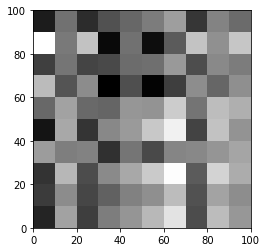

In [11]:
plt.imshow(a_new, cmap='gray', origin = 'lower',  extent = [0, 100, 0, 100],interpolation='nearest')

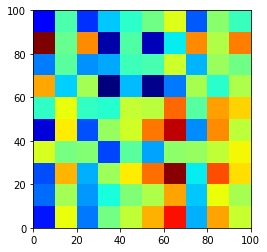

In [14]:
a = plt.imshow(a_new, cmap='jet', origin = 'lower',  extent = [0, 100, 0, 100],interpolation='nearest')
data = a.get_array()

Осталось сгенирировать достаточное число образцов. Разобраться как их хранить: png-файлами или тензорами 100х100 (что, почти одно и тоже). Это я оставлю уже на вас. Опыта у вас побольше. Т.е. нужно сформировать картинки+ранги, затем уже проводить категориальное обучение, желательно CNN. Статья предсказывает не очень высокую точность, но пример, идеологически, невероятно интересный. 

## Генерация датасета

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

Генерация

In [22]:
def generate_image(n, r):
    a=np.random.rand(n,n)
    (u,s,v)=np.linalg.svd(a)

    s_cut=np.zeros(n)
    s_cut[:r]=s[:r]

    s_mat=np.diag(s_cut)

    a_new=u.dot(s_mat).dot(v)
    
    image = a_new
    #image = cv2.resize(image, (100, 100), interpolation=cv2.INTER_NEAREST)
    image = np.uint8(255 * image)
    image = cv2.applyColorMap(image, cv2.COLORMAP_JET)
    return image

In [23]:
N = 1000
file_size = 100
n = 10

images = np.zeros((N*10, 10, 10, 3))
labels = np.zeros((N*10))
for i in range(N):
    for r in range(1, 11):
        image = generate_image(n, r)

        images[i+r-1] = image
        labels[i+r-1] = r-1

In [24]:
N_test = 100
file_size = 100
n = 10

test_images = np.zeros((N_test*10, 10, 10, 3))
test_labels = np.zeros((N_test*10))
for i in range(N_test):
    for r in range(1, 11):
        image = generate_image(n, r)

        test_images[i+r-1] = image
        test_labels[i+r-1] = r-1

In [25]:
images.shape

(10000, 10, 10, 3)

In [26]:
test_images.shape

(1000, 10, 10, 3)

Перемешивание

In [27]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [28]:
images, labels = unison_shuffled_copies(images, labels)
test_images, test_labels = unison_shuffled_copies(test_images, test_labels)

Сохранение

In [29]:
np.savez(
    "rank_prediction_small_matrix_rgb.npz", 
    x_train=images, 
    y_train=labels,
    x_test=test_images,
    y_test=test_labels
)

## Обучение модели

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

Загрузка данных

In [31]:
with np.load("rank_prediction_small_matrix_rgb.npz") as data:
    x_train = data["x_train"]
    y_train = data["y_train"]
    x_test = data["x_test"]
    y_test = data["y_test"]

Нормализация

In [32]:
x_train = keras.utils.normalize(x_train)
x_test = keras.utils.normalize(x_test)

Подготовка

In [33]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [34]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Создание модели

In [35]:
model_input = keras.layers.Input(shape=(10,10,3))

x = keras.layers.Conv2D(128, (3, 3))(model_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.MaxPooling2D()(x)

x = keras.layers.Conv2D(256, (3, 3))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(10, activation="softmax")(x)
model = keras.models.Model(model_input, x)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10, 10, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         3584      
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 256)         295168    
_________________________________________________________________
batch_normalization_4 (Batch (None, 2, 2, 256)         1024

In [36]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Обучение

In [37]:
history = model.fit(
    train_dataset,
    epochs=20, 
    validation_data=test_dataset
)

Epoch 1/20
313/313 [==============================] - 6s 21ms/step - loss: 0.5859 - acc: 0.9471 - val_loss: 0.1052 - val_acc: 0.9910
Epoch 2/20
313/313 [==============================] - 5s 18ms/step - loss: 0.0582 - acc: 0.9943 - val_loss: 0.0284 - val_acc: 0.9910
Epoch 3/20
313/313 [==============================] - 6s 18ms/step - loss: 0.0234 - acc: 0.9969 - val_loss: 0.0230 - val_acc: 0.9920
Epoch 4/20
313/313 [==============================] - 6s 18ms/step - loss: 0.0132 - acc: 0.9983 - val_loss: 0.0279 - val_acc: 0.9920
Epoch 5/20
313/313 [==============================] - 6s 18ms/step - loss: 0.0134 - acc: 0.9979 - val_loss: 0.0417 - val_acc: 0.9920
Epoch 6/20
313/313 [==============================] - 6s 18ms/step - loss: 0.0145 - acc: 0.9981 - val_loss: 0.0213 - val_acc: 0.9920
Epoch 7/20
313/313 [==============================] - 6s 18ms/step - loss: 0.0095 - acc: 0.9989 - val_loss: 0.0229 - val_acc: 0.9920
Epoch 8/20
313/313 [==============================] - 6s 18ms/step - 

In [41]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

print('\nТочность на проверочных данных:', test_acc)

32/32 - 0s - loss: 0.0293 - acc: 0.9910

Точность на проверочных данных: 0.991


In [44]:
def show_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

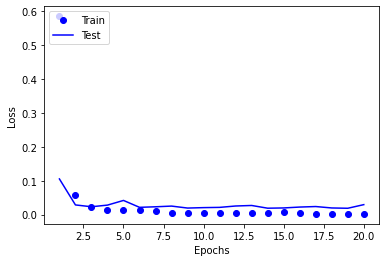

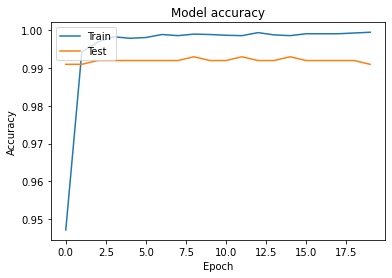

In [45]:
show_loss(history)